# Hello again, Uncertainty

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# Prediction and Estimation

Suppose I've collected data on rent in Eugene.
Consider the following questions:

1. How much does rent cost in the Bethel neighborhood this year?
2. How much is rent changing by, per year?

*Question:* What would good answers to these questions look like?

We could answer these questions by

- reporting empirical averages from the actual data
- fitting a black-box predictor and asking it questions
- fitting a model with explicit terms for neighborhood and year

*(Discuss pros and cons and how these would actually work.)*

# A third question

3. How sure are you about those answers?

> 1. How much does rent cost in the Bethel neighborhood this year?


Note that this has two notions of uncertainty:
rents come in a range of values, but also there will be uncertainty in our estimates of that range.

# Uncertainty, by math

## Reminder: confidence intervals

If we have $n$ independent samples from some source,
and the sample mean and SD are $\bar x$ and $s$ respectively,
then a 95% confidence interval is
$$ \bar x - t_n s / \sqrt{n} \qquad \text{to} \qquad \bar x + t_n s / \sqrt{n} , $$
where $t_n$ is the 97.5% quantile for the $t$ distribution with $n-1$ degrees of freedom.

*Said another way:* $\bar x$ is our estimate of the mean,
and math gives us an estimate of the uncertainty behind our estimate.

1. How much does rent cost in the Bethel neighborhood this year?

**(Take the mean of the rents in Bethel this year.)**

2. How much is rent changing by, per year?

**(Take the mean difference in rent of places that go up for rent in adjacent years.)**

3. How sure are you about those answers?

**(Get 95% CIs for them.)**

# A model

For example: suppose we fit a model where
the price of the $i^\text{th}$ apartment is
$$\begin{aligned}
    p_i &= \beta_{n_i} + \beta_\text{year} y_i + \beta_\text{area} a_i + \epsilon_i \\
    \epsilon_i &\sim \text{Normal}(0, \sigma) ,
\end{aligned}$$
where
- $p_i$ is the price (in dollars)
- $n_i$ is the neighborhood,
- $\beta_n$ is the mean price in neighborhood $n$
- $y_i$ is the year
- $\beta_\text{year}$ is the amount that rent changes by, per year, on average
- $a_i$ is the area in square feet
- $\beta_\text{area}$ is the amount that rent goes up per additional square foot, on average
- $\epsilon_i$ is the residual, and
- $\sigma$ is how much otherwise similar apartments differ in price

1. How much does rent cost in the Bethel neighborhood this year?

**(Our estimate of $\beta_\text{Bethel}$ plus terms for year and area.)**

2. How much is rent changing by, per year?

**(Our estimate of $\beta_\text{year}$.)**

3. How sure are you about those answers?

**???**

## Aside: how do we fit this model?

We'll do it in two lines,
with [patsy](https://patsy.readthedocs.io/en/latest/quickstart.html)
and `np.linalg.lstsq`. 
*(Reminder: since the residuals are Normal, least squares is the same as maximum likelihood.)*

First, let's read in [the data](data/housing.csv).
*(Note: it's fake data.)* ([github link](https://github.com/UOdsci/dsci345/raw/main/class_material/slides/data/housing.csv))

In [2]:
df = pd.read_csv("data/housing.csv", index_col=0)
df

,hood,year,area,rent
0,river,2014,489.0,942.0
1,bethel,2010,610.0,370.0
2,churchill,2017,385.0,669.0
3,bethel,2012,757.0,624.0
4,bethel,2019,504.0,990.0
...,...,...,...,...
395,bethel,2012,238.0,579.0
396,campus,2016,287.0,759.0
397,churchill,2016,526.0,679.0
398,campus,2014,418.0,868.0


Next, let's shift the variables, so that for instance
$\beta_\text{Bethel}$ is the average price of a 500 ft${}^2$ apartment in 2010
(instead of a 0 ft${}^2$ apartment in the year 0):

In [12]:
df['area'] -= 500
df['year'] -= 2010

Now, fit the model,
using patsy to make the *design matrix* (see board):

In [13]:
import patsy
outcome, predictors = patsy.dmatrices("rent ~ 0 + hood + year + area", df)
fit = np.linalg.lstsq(predictors, outcome, rcond=None)

estimates = { k.lstrip('hood[').rstrip("]") : v for k, v in zip(predictors.design_info.column_names, fit[0].ravel())}

estimates

{'bethel': 556.0088681522553,
 'campus': 649.8851743401478,
 'churchill': 584.096857622859,
 'river': 610.4626011683354,
 'whittaker': 643.2011227181556,
 'year': 31.218431226183554,
 'area': 0.10063620684195485}

In [17]:
np.asarray(predictors)[:10,:]

array([[   0.,    0.,    0.,    1.,    0.,    4.,  -11.],
       [   1.,    0.,    0.,    0.,    0.,    0.,  110.],
       [   0.,    0.,    1.,    0.,    0.,    7., -115.],
       [   1.,    0.,    0.,    0.,    0.,    2.,  257.],
       [   1.,    0.,    0.,    0.,    0.,    9.,    4.],
       [   0.,    0.,    0.,    0.,    1.,    5.,  -16.],
       [   0.,    0.,    0.,    1.,    0.,    6.,   93.],
       [   1.,    0.,    0.,    0.,    0.,    4., -196.],
       [   1.,    0.,    0.,    0.,    0.,    3.,  163.],
       [   0.,    1.,    0.,    0.,    0.,    2.,   81.]])

In [18]:
df

,hood,year,area,rent
0,river,4,-11.0,942.0
1,bethel,0,110.0,370.0
2,churchill,7,-115.0,669.0
3,bethel,2,257.0,624.0
4,bethel,9,4.0,990.0
...,...,...,...,...
395,bethel,2,-262.0,579.0
396,campus,6,-213.0,759.0
397,churchill,6,26.0,679.0
398,campus,4,-82.0,868.0


# Uncertainty, by simulation

Okay, so we'd like to know
how far off our guesses of $\beta_\text{Bethel}$ or $\beta_a$ are
from "the truth".

Well, one way to do this is to *simulate* data where we know the truth,
and then see how far off our guesses are.
If the simulations describe the real data well, 
then this should give us a good estimate.

This is sometimes known as *the parametric bootstrap*.
(We'll meet it's more famous cousin, "the" bootstrap, next.)
We actually did it, last class.
Let's do it again!

Okay, from our "real data" we estimated a certain set of estimated parameter values.
To make the simulated datasets look as much like the real data as possible,
we should simulate using those parameter values.

In [19]:
def sim_rents(df, beta):
    # TODO: estimate sigma
    sim_df = df.copy()
    sim_df['rent'] = np.round(
        np.array([beta[h] for h in sim_df.hood]) + beta['year'] * sim_df.year + beta['area'] * sim_df.area
        + rng.normal(scale=150, size=len(df))
    )
    return sim_df

In [20]:
def fit_model(df):
    outcome, predictors = patsy.dmatrices("rent ~ 0 + hood + year + area", df)
    fit = np.linalg.lstsq(predictors, outcome, rcond=None)
    estimates = { k.lstrip('hood[').rstrip("]") : v for k, v in zip(predictors.design_info.column_names, fit[0].ravel())}
    return estimates

In [21]:
estimates

{'bethel': 556.0088681522553,
 'campus': 649.8851743401478,
 'churchill': 584.096857622859,
 'river': 610.4626011683354,
 'whittaker': 643.2011227181556,
 'year': 31.218431226183554,
 'area': 0.10063620684195485}

In [22]:
experiments = pd.DataFrame([
    fit_model(sim_rents(df, beta=estimates))
    for _ in range(1000)
])
experiments

,bethel,campus,churchill,river,whittaker,year,area
0,584.166142,669.344459,574.731355,591.671821,608.832851,31.493292,0.167410
1,548.470520,642.081607,595.742004,600.295146,666.204431,31.388636,0.069435
2,547.651974,638.041640,575.990943,615.388108,646.721045,31.595768,0.062728
3,536.316663,654.783653,555.725922,569.821275,619.417161,34.060227,0.134359
4,531.365627,642.714180,549.097306,599.470425,620.595974,35.858746,0.186808
...,...,...,...,...,...,...,...
995,571.000615,652.546163,591.171362,613.168836,620.567379,32.368239,0.076406
996,563.204296,651.825988,575.818048,585.150447,635.718936,32.763511,0.116031
997,535.515492,672.482377,585.800205,619.261592,630.486191,32.680833,0.122732
998,566.963529,652.628457,586.192732,601.332649,630.896443,33.485426,0.165508


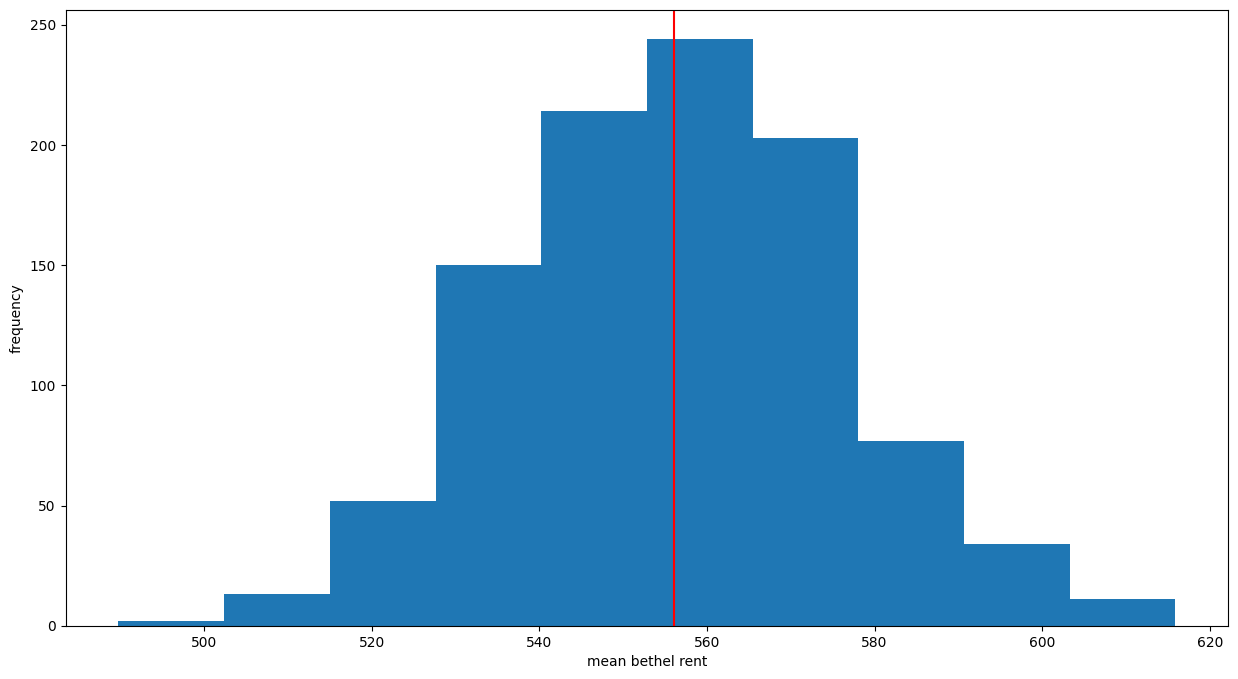

In [23]:
plt.hist(experiments.bethel)
plt.xlabel("mean bethel rent"); plt.ylabel("frequency");
plt.axvline(estimates['bethel'], color='red');

**Conclusion:** The mean rent in Bethel for 500 ft${}^2$ apartments in 2010
as about \\$556, with a 95\% confidence interval of about \\$518 to \\$595.

Widths of other 95\% confidence intervals are below.

In [26]:
estimates

{'bethel': 556.0088681522553,
 'campus': 649.8851743401478,
 'churchill': 584.096857622859,
 'river': 610.4626011683354,
 'whittaker': 643.2011227181556,
 'year': 31.218431226183554,
 'area': 0.10063620684195485}

In [24]:
experiments.quantile(0.975) - experiments.quantile(0.025)

bethel       75.792440
campus       85.024373
churchill    77.645715
river        80.409836
whittaker    83.334995
year         10.468143
area          0.191446
dtype: float64

# Uncertainty, by our bootstraps

*However*, sometimes we don't have
(or can't be bothered to make)
a good generative model
to simulate from.
Or we tried and it was hard to get realistic-looking data.
What to do then?

Well, what we'd *like* to do is to draw a bunch of new datasets
from wherever we got the first one.

This seems unrealistic... *but*, our best guess at what that would be like if we could...
is our dataset itself!

## The bootstrap

Suppose we have a method that estimates something.
To get an estimate of *uncertainty* of that estimate,

1. Obtain a new dataset, of the same size as the original,
    by resampling *with replacement* observations from the original dataset.
    
2. Apply the method to this 'bootstrapped' dataset.

3. Repeat lots of times.

Then, the middle 95% of the estimates
gives you the "bootstrap 95% confidence interval".

## Exercise:

Here are 10 numbers.
```
array([176, 255,  53,  94,  61, 119,  42, 109,   0,  30])
```

1. Compute the median.
2. 1,000 times, resample 10 numbers, with replacement, from this list of numbers,
    and compute the median.
3. Make a histogram of those 1,000 medians, with the original median as a vertical line.

In [37]:
# IN CLASS
x = np.array([176, 255,  53,  94,  61, 119,  42, 109,   0,  30])
med_x = np.median(x)

In [36]:
boot_meds = [np.median(rng.choice(x, size=10, replace=True)) for _ in range(1000)]

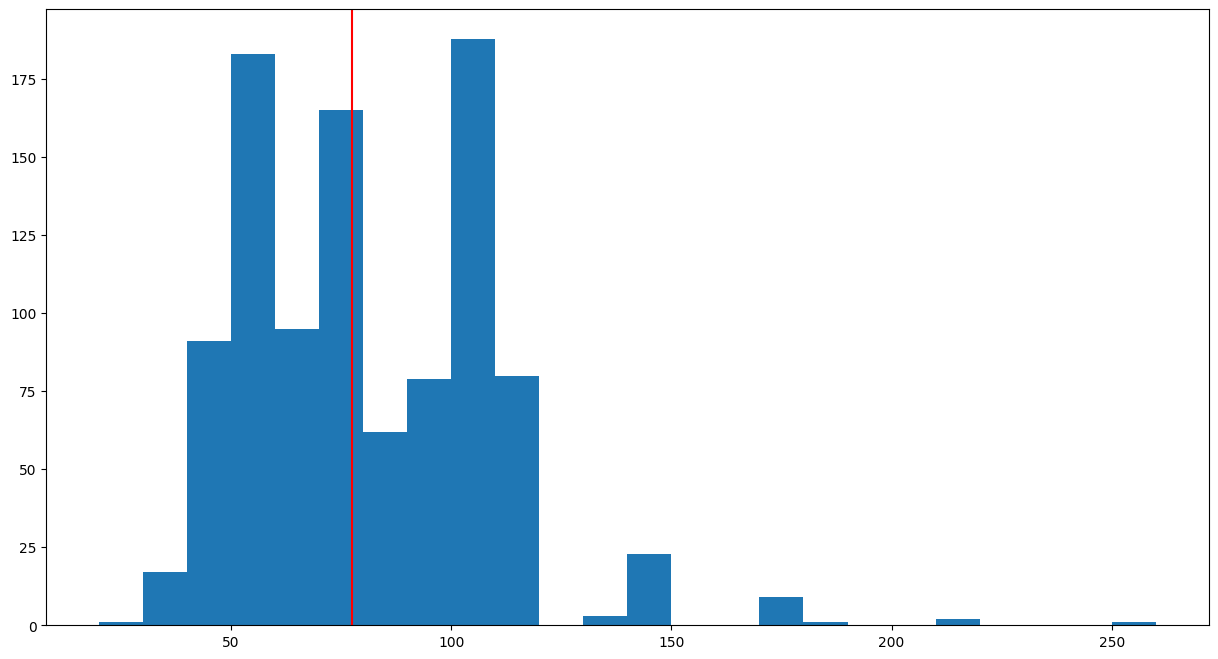

In [46]:
fig, ax = plt.subplots()
ax.hist(boot_meds, bins=pretty(boot_meds, 20))
ax.axvline(med_x, c='red');

In [47]:
# 95% confidence interval
(np.quantile(boot_meds, 0.025), np.quantile(boot_meds, 0.975))

(42.0, 142.6249999999999)

Here's a (very) simple method to obtain a bootstrap resampled version of a data frame:

In [48]:
def bootstrap(df):
    n = df.shape[0]
    return df.loc[rng.choice(n, n)]

And, here, let's apply the`fit_model` method above to 1000 of these.

In [49]:
boots = pd.DataFrame([
    fit_model(bootstrap(df))
    for _ in range(1000)
])
boots

,bethel,campus,churchill,river,whittaker,year,area
0,560.210451,636.016871,578.413202,619.843782,667.053935,30.274924,0.047091
1,564.531604,622.427456,588.565815,613.542364,638.936977,31.627643,0.026321
2,567.543019,627.054073,572.087178,595.868772,626.018438,33.476634,0.139231
3,529.557267,686.867199,596.213492,589.702256,625.340334,31.717146,0.163151
4,554.290280,671.216130,606.793057,619.289359,674.408295,30.395264,0.092401
...,...,...,...,...,...,...,...
995,561.655127,632.217128,596.172648,569.205587,630.093907,31.005708,0.086366
996,566.418449,660.594556,566.797056,610.844184,644.450902,31.040472,0.176374
997,558.289485,672.877620,606.194516,636.635536,658.130228,27.092402,0.092001
998,554.571696,638.935515,577.161752,591.444945,640.712619,32.526722,0.098845


And, here is the distribution of estimates of $\beta_\text{Bethel}$.
It is similar, but not identical, to our other distribution above (as expected).

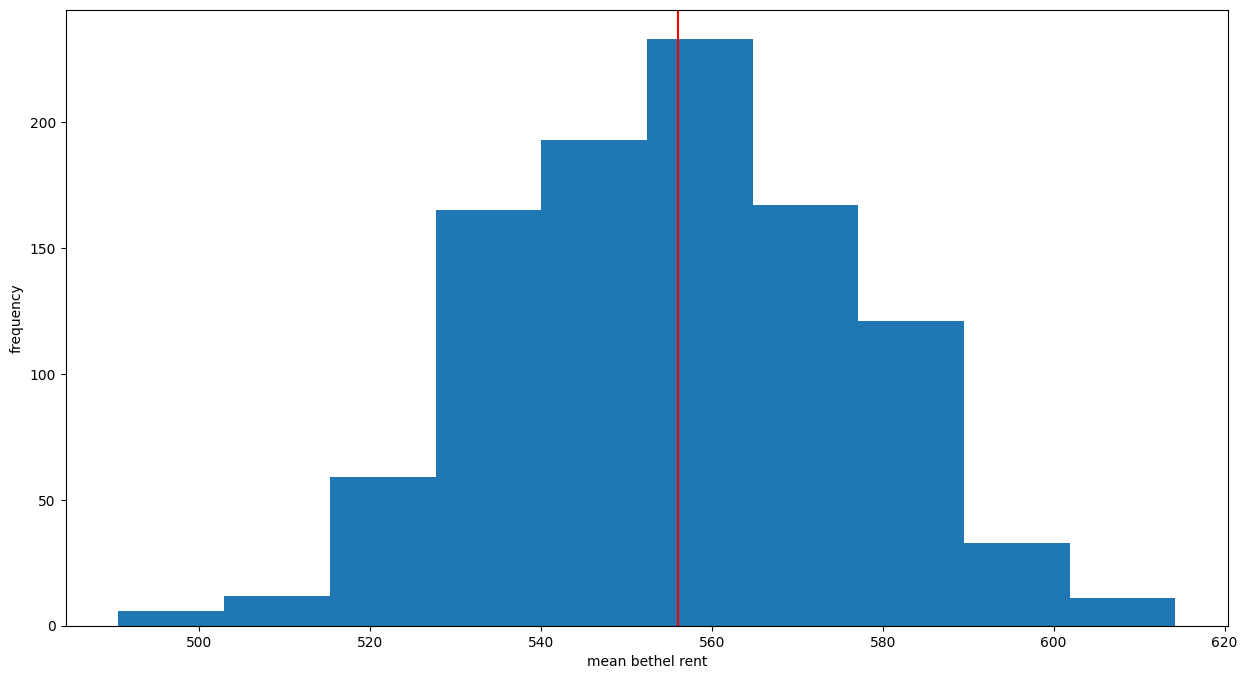

In [50]:
plt.hist(boots.bethel)
plt.xlabel("mean bethel rent"); plt.ylabel("frequency");
plt.axvline(estimates['bethel'], color='red');

**Conclusion:** The mean rent in Bethel for 500 ft${}^2$ apartments in 2010
as about \\$556, with a 95\% confidence interval of about \\$518 to \\$595.

Widths of other 95\% confidence intervals are below.

In [52]:
boots.quantile(0.975) - boots.quantile(0.025)

bethel       76.281754
campus       83.879112
churchill    86.591591
river        79.459017
whittaker    81.761172
year         10.911707
area          0.200773
dtype: float64